In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from scipy.io import wavfile
from scipy.signal import decimate

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
# For colab users
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
INPUT_LIB = '/content/drive/MyDrive/기타/NPEX4기_test/heartbeat/heartbeat/'
SAMPLE_RATE = 44100
CLASSES = ['artifact', 'normal', 'murmur']
CODE_BOOK = {x:i for i,x in enumerate(CLASSES)}   
NB_CLASSES = len(CLASSES)

### Load data

In [4]:
def load_wav_file(name, path):
    _, b = wavfile.read(path + name)
    assert _ == SAMPLE_RATE
    return b

In [5]:
def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, 
       and makes datatype float"""
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

In [6]:
# # Example of DataFrame.apply() function
# _dict = {1: {0:1, 1:1, 3:3}}
# _df = pd.DataFrame()
# _df = _df.from_dict(_dict)
# _d = {1: 'one', 2: 'two', 3: 'three'}
# def _mapping(x):
#     _d2 = {1: 'one', 2: 'two', 3: 'three'}
#     return _d2[x]

# _df["func"] = _df[1].apply(_mapping)
# _df["lamb"] = _df[1].apply(lambda x: _d[x])
# _df

In [7]:
df = pd.read_csv(INPUT_LIB + 'input.csv')
df['time_series'] = df['file_name'].apply(load_wav_file, 
                                          path=INPUT_LIB + 'set_a/')    
df['len_series'] = df['time_series'].apply(len)
MAX_LEN = max(df['len_series'])
df['time_series'] = df['time_series'].apply(repeat_to_length, 
                                            length=MAX_LEN) 

In [8]:
df.head()

,index,file_name,labels,time_series,len_series
0,0,artifact__201012172012.wav,0,"[1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...",396900
1,1,artifact__201105040918.wav,0,"[-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...",396900
2,2,artifact__201105041959.wav,0,"[6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...",396900
3,3,artifact__201105051017.wav,0,"[-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...",396900
4,4,artifact__201105060108.wav,0,"[53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...",396900


### Split the data

In [9]:
x_data = np.stack(df['time_series'].values, axis=0)
y_data = pd.get_dummies(df['labels'].values.tolist()).values

In [10]:
x_train, x_test, y_train, y_test, train_filenames, test_filenames = \
    train_test_split(x_data, y_data, df['file_name'].values, test_size=0.25)

In [11]:
x_train = decimate(x_train, 8, axis=1)
x_train = decimate(x_train, 8, axis=1)
x_train = decimate(x_train, 4, axis=1)

x_test = decimate(x_test, 8, axis=1)
x_test = decimate(x_test, 8, axis=1)
x_test = decimate(x_test, 4, axis=1)

In [17]:
# # print(x_train.shape, np.std(x_train, axis=1).shape)
# # print(x_train/np.std(x_train, axis=1)) # Error

# # print((x_train/np.std(x_train, axis=1).reshape(-1,1)).shape)

# A = np.arange(20).reshape(5,4)
# B = np.arange(1,6)
# print("* A: ")
# print(A)
# print("* B: ")
# print(B)
# # print(A/B)
# print("* A/B: ")
# print(A/B.reshape(-1,1))

* A: 
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]
* B: 
[1 2 3 4 5]
* A/B: 
[[0.         1.         2.         3.        ]
 [2.         2.5        3.         3.5       ]
 [2.66666667 3.         3.33333333 3.66666667]
 [3.         3.25       3.5        3.75      ]
 [3.2        3.4        3.6        3.8       ]]


In [18]:
x_train = x_train / np.std(x_train, axis=1).reshape(-1,1)
x_test = x_test / np.std(x_test, axis=1).reshape(-1,1)

In [19]:
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

In [20]:
print(f"X train shape: {x_train.shape}")
print(f"X test  shape: {x_test.shape}")

X train shape: (132, 1551, 1)
X test  shape: (44, 1551, 1)


### Define the model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
def create_cnn(pkeep=0.1):    
    model = Sequential()    
    
    model.add(Conv1D(filters=2, kernel_size=9, 
                     padding='same',activation='relu', 
                     input_shape=x_train.shape[1:])) # 132, 1551, 1
    model.add(MaxPool1D(pool_size=4, strides=4, padding='same'))

    model.add(Conv1D(filters=2, kernel_size=9,
                     padding='same',activation='relu'))
    model.add(MaxPool1D(pool_size=4, strides=4, padding='same'))
    
    model.add(Conv1D(filters=4, kernel_size=9,
                     activation='relu', padding='same'))
    model.add(MaxPool1D(pool_size=4, strides=4, padding='same'))
    
    model.add(Conv1D(filters=6, kernel_size=9, 
                     padding='same', activation='relu'))
    model.add(MaxPool1D(pool_size=4, strides=4, padding='same'))
    
    model.add(Flatten())
    model.add(Dropout(1-pkeep)) # probability to drop
    model.add(Dense(units=3, activation = 'softmax'))  # loss, from_logits, logits: False
    # print(model.summary())    
    return model
# model = create_cnn(0.5) #Tensorflow conv1D , conv2D padding 'SAME'
# Stride 1 --> output=input
# Stide > 1 --> output = Ceiling(input/Stride)

### Train the model

In [29]:
pkeep = 0.5
batch_size = 8
epochs = 100

In [36]:
model = create_cnn(pkeep)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer = opt, 
              metrics = ['accuracy'])

In [37]:
hists = model.fit(x_train, y_train, 
                  batch_size=batch_size, epochs=epochs, validation_split=0.2,
                  callbacks=[EarlyStopping(monitor="val_loss", patience=10, 
                                           restore_best_weights=True)])
# Max epoch 100 , early stopping에 의해 학습 80번째 멈춤. 
# --> 70번째 에폭의 모델이 가장 좋은 모델
# Valid loss: [ ....... 0.9 0.8 0.9 0.91 0.95], patience: 10

Epoch 1/100
14/14 [==============================] - 1s 29ms/step - loss: 1.1669 - accuracy: 0.3619 - val_loss: 1.1349 - val_accuracy: 0.2593
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 1.2350 - accuracy: 0.3429 - val_loss: 1.1205 - val_accuracy: 0.2963
Epoch 3/100
14/14 [==============================] - 0s 13ms/step - loss: 1.1642 - accuracy: 0.4000 - val_loss: 1.1103 - val_accuracy: 0.3333
Epoch 4/100
14/14 [==============================] - 0s 13ms/step - loss: 1.0428 - accuracy: 0.4286 - val_loss: 1.1032 - val_accuracy: 0.4074
Epoch 5/100
14/14 [==============================] - 0s 13ms/step - loss: 1.0429 - accuracy: 0.4762 - val_loss: 1.0996 - val_accuracy: 0.4074
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 1.0166 - accuracy: 0.4571 - val_loss: 1.0978 - val_accuracy: 0.4074
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 1.0296 - accuracy: 0.4762 - val_loss: 1.0943 - val_accuracy: 0.4074
Epoch 

### Plot the training result

In [38]:
loss = hists.history['loss']
val_loss = hists.history['val_loss']

In [39]:
acc = hists.history['accuracy']
val_acc = hists.history['val_accuracy']

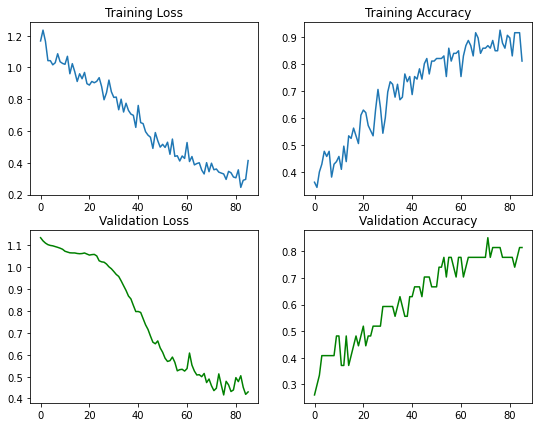

In [40]:
plt.figure(figsize=(9, 7))

plt.subplot(221)
plt.title("Training Loss")
plt.plot(loss)

plt.subplot(222)
plt.title("Training Accuracy")
plt.plot(acc,)

plt.subplot(223)
plt.title("Validation Loss")
plt.plot(val_loss,  color='green')

plt.subplot(224)
plt.title("Validation Accuracy")
plt.plot(val_acc, color='green')

plt.show()

### Plot the test result

In [ ]:
preds = tf.argmax(model.predict(x_test), 1)
labels = tf.argmax(y_test, 1)

In [ ]:
accuracy_op = tf.keras.metrics.Accuracy()
test_acc = accuracy_op(preds, labels).numpy()

Accuracy = 0.73


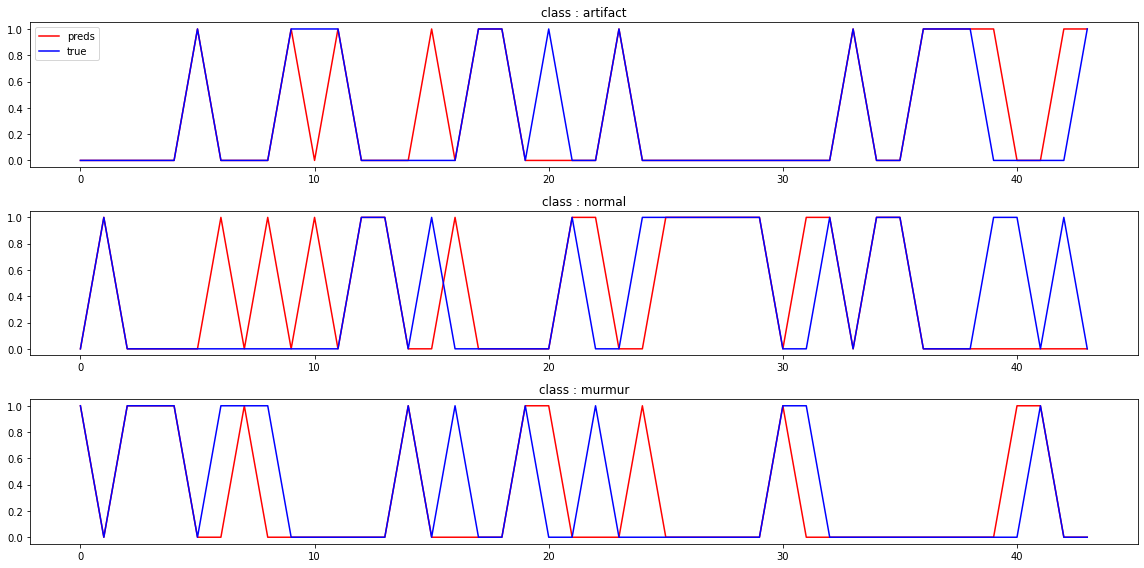

In [ ]:
result = pd.get_dummies(preds).values
fig = plt.figure(figsize=(16, 8))
print(f"Accuracy = {test_acc:.2f}")
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(result[:,i], c='r')
    plt.plot(y_test[:,i], c='b')
    plt.title(f"class : {CLASSES[i]}")
    if i == 0:
        plt.legend(['preds',  'true'])
fig.tight_layout()

In [ ]:
mis_preds = [ i for i in range(len(labels)) if (preds[i].numpy() != labels[i].numpy())]

num = len(mis_preds)

print(f"the number of mis-prediction: {num}")

: 

In [ ]:
# for i in range(num):
#     idx = mis_preds[i]
#     print(preds[idx].numpy() == labels[idx].numpy())

: 

In [ ]:
row = 4
col = int(np.ceil(num/row))

: 

In [ ]:
fig = plt.figure(figsize=(20, 12))

for i in range(num):
    plt.subplot(row, col, i+1)
    plt.plot(x_test[mis_preds[i]]) # mis_preds: [0, 10, 15]
    plt.title(f"{i+1}. File: {test_filenames[mis_preds[i]]}\n" 
              f"Pred: {CLASSES[preds[mis_preds[i]]]},"
              f"True: {CLASSES[labels[mis_preds[i]]]}")
    
fig.tight_layout()

: 

: 